<a href="https://colab.research.google.com/github/TA-aiacademy/course_3.0/blob/GAI/08_GAI/GAI_Part1/Autoencoder_與_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoder and Variational Autoencoder

本章節我們將介紹並帶各位同學實作非監督式學習中的自編碼器及其變形。

## 1: 匯入所需套件

In [ ]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [ ]:
print(tf.__version__)

2.15.0


## 2: 下載並整理資料集

In [ ]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

11490434/11490434 [==============================] - 0s 0us/step


## 3 Autoencoder

Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，通常由一編碼器及一解碼器所組成。

<p align="center">
  <img src="https://hackmd.io/_uploads/S199Ud3hh.png", width="70%"
   />
</p>

給定一組資料集 $\mathcal{D}\subseteq\mathbb{R}^n$ 以及一個壓縮維度 $m$，其中 $m < n$。

數學上來說表示，Autoencoder 由 $\mbox{Enc}:\mathbb{R}^n\to\mathbb{R}^m$ 和 $\mbox{Dec}:\mathbb{R}^m\to\mathbb{R}^n$ 所構成：

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} z \overset{\mbox{Dec}}{\mapsto} x' $$

其中，$z = \mbox{Enc}(x)$ 稱之 $x$ 透過 Encdoer 得到的潛在表示法 (latent representation)。

Decoder 的目的則是將潛在空間 (Latent Sapce) 裡的元素轉換為特徵空間 (Feature Space) 中的元素，因此，我們希望 Decoder 能將 $x$ 的潛在表示 $z$，還原成 $x'$。

Autoencodr 就是一組函數 ($Enc$, $Dec$) 使得，對於任意的 $x\in\mathcal{D}$，$x\approx{x'} = Dec(z) = Dec\big(Enc(x)\big)$


**為了視覺化的目的，我們採用 $z=2$ 的狀況。**

### 3.1 Autoencoder

為了方便，我們將三個變數的符號表示出來：

$$ x \overset{\mbox{Enc}}{\mapsto} z \overset{\mbox{Dec}}{\mapsto} x' $$

In [ ]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

# Define latent repre. of x
z = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(z))

In [ ]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
 dense_2 (Dense)             (None, 100)               300       
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
Total params: 158186 (617.91 KB)
Trainable params: 158186 (617.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [ ]:
autoencoder.compile(loss='mse',
                    optimizer=Adam(5e-3),
                    metrics=['mae']
                    )

# autoencoder.load_weights('autoencoder_mse_mae_weights.h5')

In [ ]:
autoencoder.fit(X_train, X_train,
                batch_size=512,
                epochs=5,
                validation_data=(X_test, X_test)
                )

# autoencoder.save_weights('autoencoder_mse_mae_weights.h5')

Epoch 1/5
118/118 [==============================] - 5s 37ms/step - loss: 0.0724 - mae: 0.1674 - val_loss: 0.0661 - val_mae: 0.1513
Epoch 2/5
118/118 [==============================] - 4s 36ms/step - loss: 0.0635 - mae: 0.1473 - val_loss: 0.0618 - val_mae: 0.1445
Epoch 3/5
118/118 [==============================] - 4s 31ms/step - loss: 0.0611 - mae: 0.1418 - val_loss: 0.0605 - val_mae: 0.1415
Epoch 4/5
118/118 [==============================] - 5s 39ms/step - loss: 0.0580 - mae: 0.1369 - val_loss: 0.0560 - val_mae: 0.1334
Epoch 5/5
118/118 [==============================] - 4s 36ms/step - loss: 0.0560 - mae: 0.1319 - val_loss: 0.0554 - val_mae: 0.1310


### 3.2 視覺化 - 資料還原與還原誤差

In [ ]:
def reconstructed_img(idx):
    # Prepare image to be reconstructed
    X = X_train[idx:idx+1]
    y = y_train0[idx]
    X_hat = autoencoder.predict(X)

    # Reshape for plotting
    X = X.reshape(28, 28)
    X_hat = X_hat.reshape(28, 28)
    rec_error = np.abs(X-X_hat)

    # Prepare a canvas for plotting
    plt.figure(figsize=(12, 9))
    ax1 = plt.subplot2grid((2,3),(0,0))
    ax2 = plt.subplot2grid((2,3),(0,1))
    ax3 = plt.subplot2grid((2,3),(0,2))
    ax4 = plt.subplot2grid((2,3),(1,0), colspan=3)

    # Plot raw image
    ax1.imshow(X, 'Greys')
    ax1.set_title(f'Number: {y}')

    # Plot reconstructed image
    ax2.imshow(X_hat, 'Greys')
    ax2.set_title('Reconstructed Image')

    # Plot reconstruction error
    ax3.imshow(rec_error, 'Greys')
    ax3.set_title('Reconstructed Error')
    ax4.hist(rec_error.flatten(), bins=20, rwidth=0.5)
    ax4.set_title('Histogram of Reconstructed Error')

interactive(children=(IntSlider(value=3, description='idx', max=60000), Output()), _dom_classes=('widget-inter…

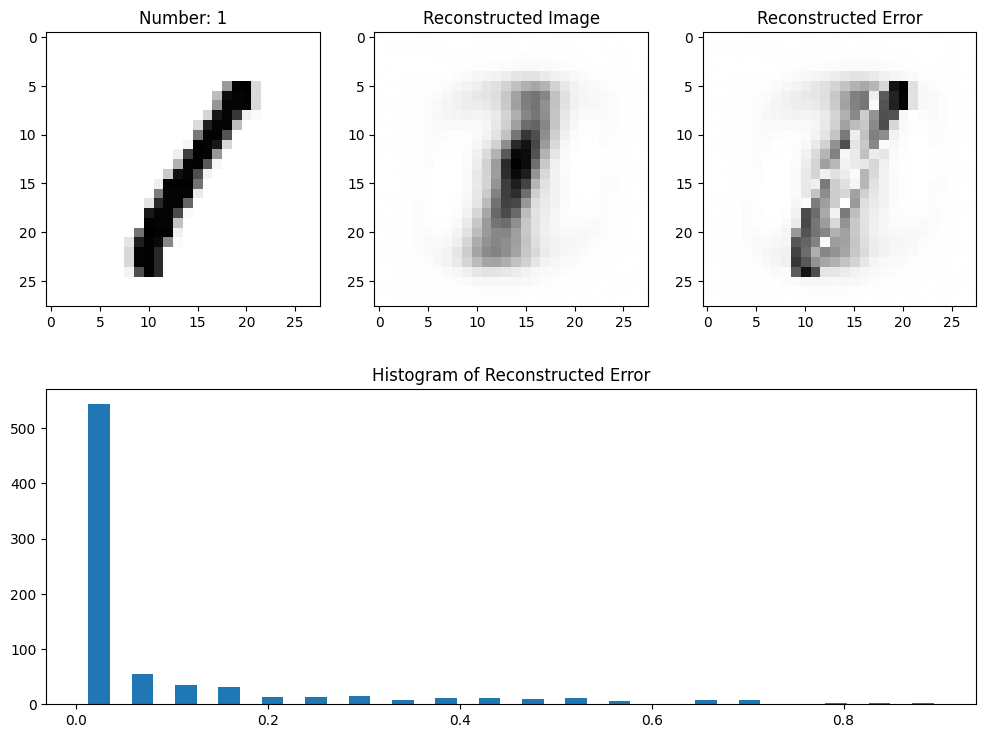

In [ ]:
# Plot
interact(reconstructed_img, idx=IntSlider(min=0, max=X_train.shape[0], step=1, value=3));

### 3.3 Encoder 與 Decoder
為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

In [ ]:
Encoder = Model(x, z)
Encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 78702 (307.43 KB)
Trainable params: 78702 (307.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 此為錯誤範例
Decoder = Model(z, x_hat)

Decoder 是由 $h$ 開始，因此，我們先準備一個與 $h$ 相同大小的 `Input`，並餵進 `dec_2` 及 `dec_1` 中即可。

In [ ]:
z_input = Input(shape=(2,))
Decoder = Model(z_input, dec_1(dec_2(z_input)))

Decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 100)               300       
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
Total params: 79484 (310.48 KB)
Trainable params: 79484 (310.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.4 視覺化 - Encoder

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

In [ ]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {Encoder.predict(X_train[idx: idx+1]).squeeze()}")

1/1 [==============================] - 0s 126ms/step
第 35849 圖的 latent 表示為 [0.09389284 0.7805101 ]


接者，我們從 $60000$ 筆訓練資料隨機挑選 $3000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [ ]:
indices = np.random.randint(X_train.shape[0], size=3000)

94/94 [==============================] - 0s 4ms/step


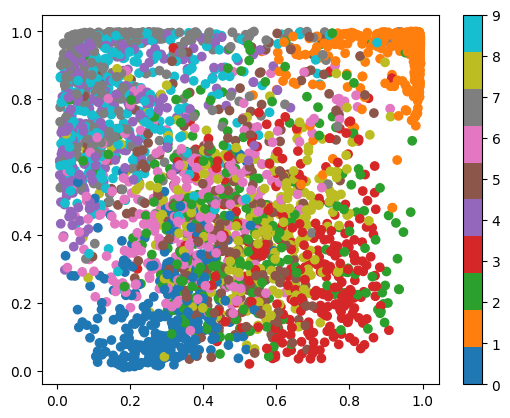

In [ ]:
latents = Encoder.predict(X_train[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_train0[indices], cmap="tab10")
plt.colorbar()
plt.show()

### 3.4 視覺化 - Decoder

首先，我們在 $[0, 1]\times[0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [ ]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

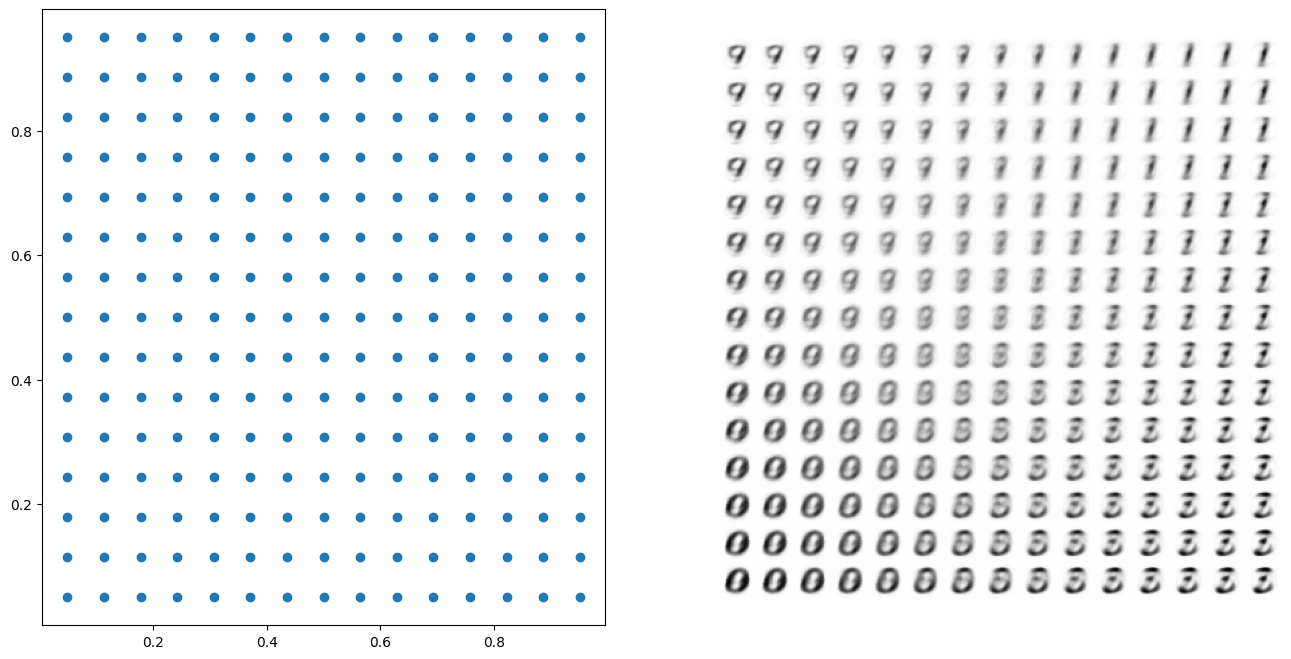

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XX, YY = np.meshgrid(grid_x, grid_y)
plt.scatter(XX, YY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

# 4.Variational Autoencoder
若每筆資料的 Latent 不僅僅是一個**位置**，而是一個分佈 (distribution) 的參數 (parameter)

如果我們希望透過抽樣 (sampling) 的方式還原圖片

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

此時 $\mbox{Enc}$ 和 $\mbox{Dec}$ 並不直接串接，而是會透過一常態抽樣的函數以下面的形式串接。

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} x' $$

<p align="center">
  <img src="https://hackmd.io/_uploads/S1Y3Idnnn.png", width="70%"
   />
</p>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

要注意到的是，由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## 4.1 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [ ]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [ ]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [ ]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [ ]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 100)                  78500     ['input_4[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 2)                    202       ['dense_4[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 2)                    202       ['dense_4[0][0]']             
                                                                                            

## 4.2 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

首先，我們要知道的是 KL-散度 (Kullback-Leibler divergence)

對於兩個機率分佈 $P$ 跟 $Q$，$P$ 相對於 $Q$ 的 KL 定義為:
$$
DL(P||Q) = E_{P}\bigg[\frac{dP}{dQ}\bigg]
$$

若 $p$ 與 $q$ 分別為 $P$ 與 $Q$ 的機率密度函數 (pdf)，則
$$
DL(P||Q) = \int_{-\infty}^\infty p(x)\frac{p(x)}{q(x)} dx.
$$

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：

若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則
$$
KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}.
$$

如果 $q\sim N(0, 1)$，則
$$
KL(p, q) = -\frac{1}{2}\bigg[1+\log\sigma_1^2-\mu_1^2-\sigma_1^2\bigg].
$$

In [ ]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 4.3 訓練 VAE

In [ ]:
VAE.compile(optimizer=Adam())

# VAE.load_weights('VAE_handwriting_model_weights.h5')

In [ ]:
VAE.fit(X_train, X_train,
        batch_size=512,
        epochs=5)

VAE.save_weights('VAE_handwriting_model_weights.h5')

Epoch 1/5
118/118 [==============================] - 3s 16ms/step - loss: 72.0371
Epoch 2/5
118/118 [==============================] - 2s 19ms/step - loss: 53.2351
Epoch 3/5
118/118 [==============================] - 3s 21ms/step - loss: 51.2321
Epoch 4/5
118/118 [==============================] - 2s 16ms/step - loss: 49.6227
Epoch 5/5
118/118 [==============================] - 2s 16ms/step - loss: 48.2255


## 4.4 VAE 的視覺化呈現
與 Autoencoder 一樣，我們來視覺化 VAE 上的 Encoder 跟 Decoder

$$\mbox{VAE:}~x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} x' $$
$$\mbox{Encoder:}~x \overset{\mbox{Enc}}{\mapsto} \mu$$
$$\mbox{Decoder:}~h \overset{\mbox{Dec}}{\mapsto} x' $$

In [ ]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 78702 (307.43 KB)
Trainable params: 78702 (307.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 100)               300       
                                                                 
 dense_8 (Dense)             (None, 784)               79184     
                                                                 
Total params: 79484 (310.48 KB)
Trainable params: 79484 (310.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [ ]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

1/1 [==============================] - 0s 50ms/step
第 49078 圖的 latent 表示為 [-0.6913854   0.95263475]


In [ ]:
VAE_latents = VAE_Encoder.predict(X_train[indices])

94/94 [==============================] - 0s 2ms/step


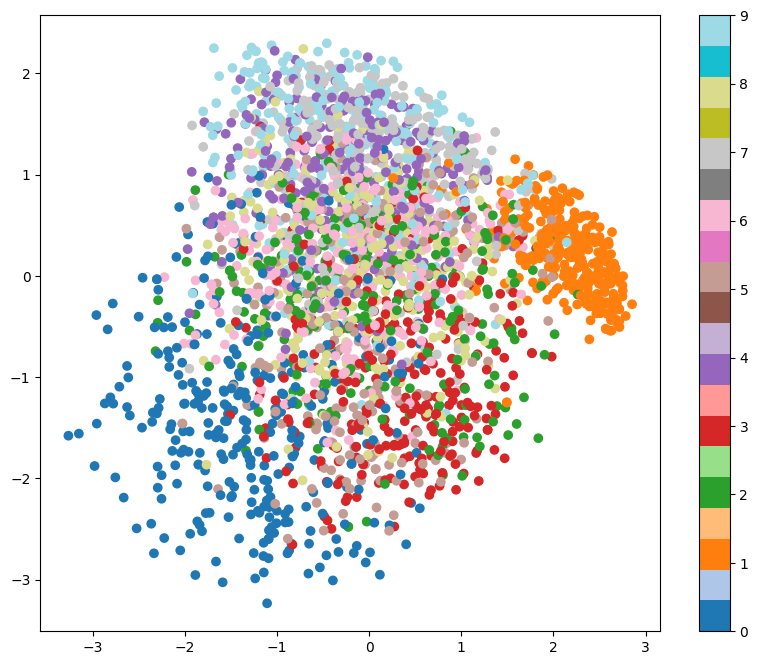

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

接著，我們進行 Decoder 的視覺化呈現。

In [ ]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [ ]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

1/1 [==============================] - 0s 28ms/step


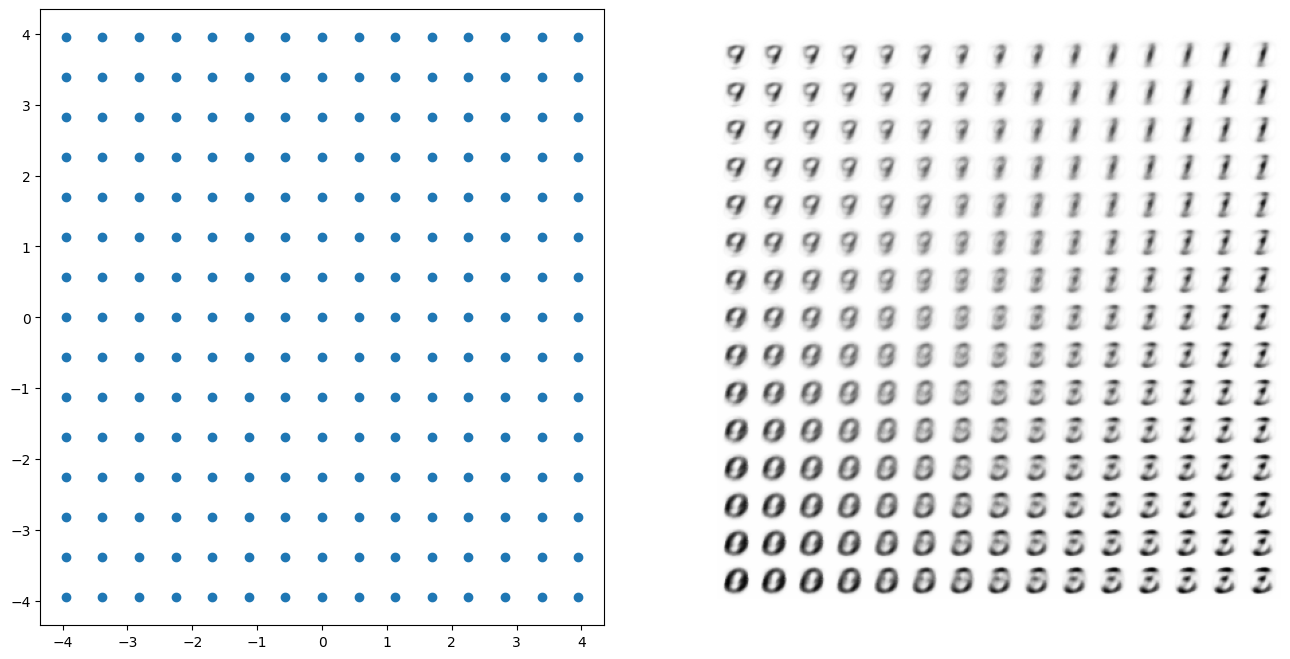

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

## 4.5 與 Autoencoder 的 Encoder 進行視覺化比較

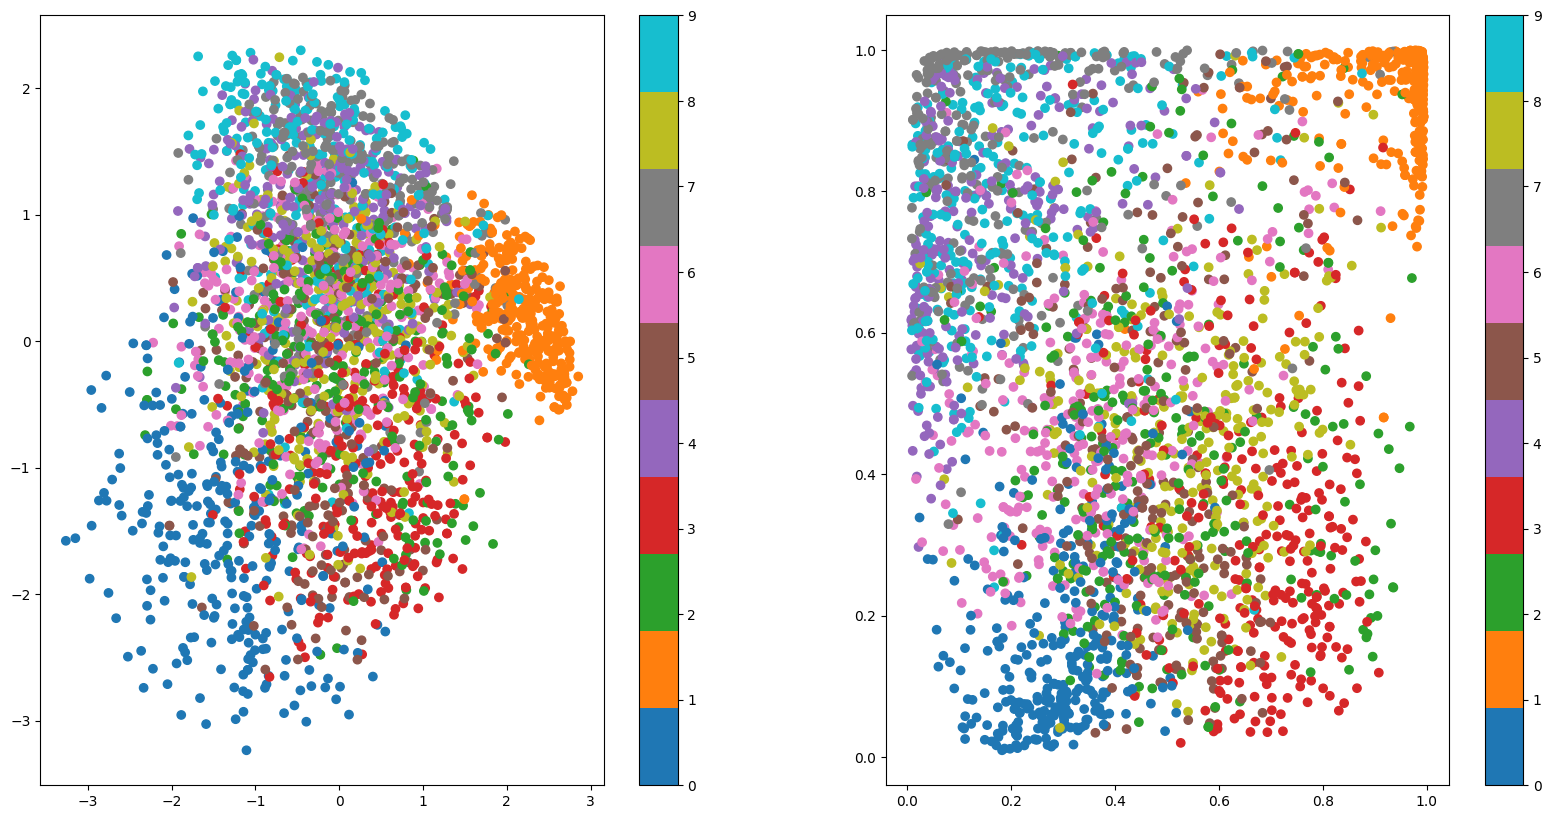

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab10')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_train0[indices], cmap="tab10")
plt.colorbar()
plt.show()

## 4.6 動態比較

In [ ]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [ ]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1

    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>

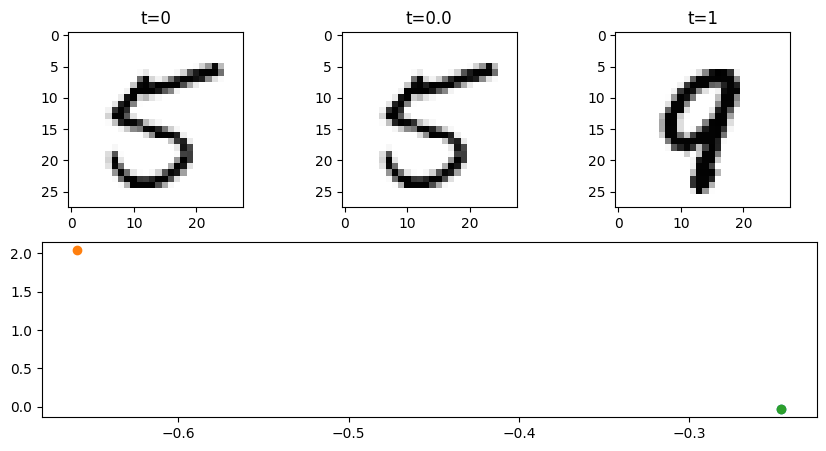

In [ ]:
interact(inBetween, t=FloatSlider(value=0,
                                  min=0,
                                  max=1.0,
                                  step=0.02,))